
Test the functions related to getCommunities().

@author: Guihong Wan and Boshen Yan      
@date: July 20, 2023

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import anndata as ad
import statistics

In [2]:
import spacells as spc

In [3]:
np.random.seed(42)
print(ad.__version__)

0.9.1


# Read data

In [4]:
adata = ad.read('../data/example_adata.h5ad')
adata.obs["id"] = adata.obs_names

The following steps compute the communities based on SOX10+ or CD45+ cells.

In [5]:
adata

AnnData object with n_obs × n_vars = 137816 × 7
    obs: 'X_centroid', 'Y_centroid', 'id'
    uns: 'all_markers'

In [6]:
print(list(adata.var_names))

['SOX10', 'CD8A', 'CD3E', 'CD45', 'panCK', 'CD4', 'aSMA']


In [7]:
markders_of_interest = ["SOX10","CD45"]

# setGate or setGates

In [8]:
spc.prep.setGate(adata, "SOX10", 7.5, debug = True)
spc.prep.setGate(adata, "CD45", 8.0, debug = True)

SOX10_b
False    91523
True     46293
Name: count, dtype: int64
CD45_b
False    98518
True     39298
Name: count, dtype: int64


In [9]:
gate_file = "../data/example_gates.csv"
spc.prep.setGates(adata, gate_file, debug = True)

gate: 7.5 SOX10_b
False    91523
True     46293
Name: count, dtype: int64
gate: 7.0 CD8A_b
False    116836
True      20980
Name: count, dtype: int64
gate: 7.2 CD3E_b
False    111855
True      25961
Name: count, dtype: int64
gate: 8.0 CD45_b
False    98518
True     39298
Name: count, dtype: int64
gate: 6.5 panCK_b
False    129174
True       8642
Name: count, dtype: int64
gate: 7.4 CD4_b
False    113595
True      24221
Name: count, dtype: int64
gate: 5.7 aSMA_b
False    129847
True       7969
Name: count, dtype: int64


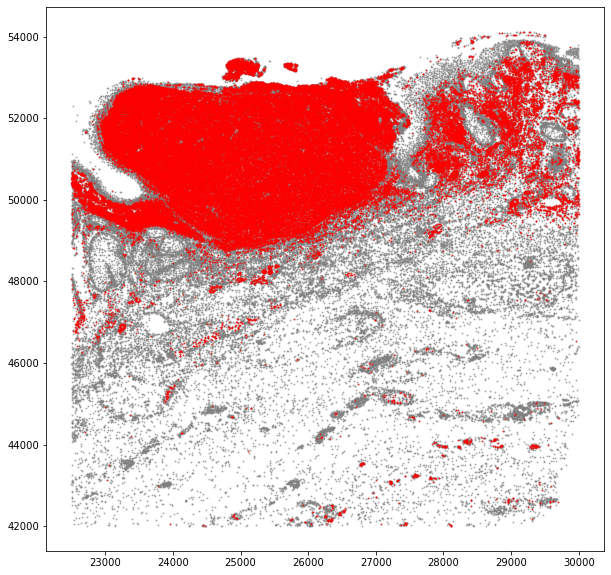

In [10]:
fig, ax = plt.subplots(figsize=(10, 10))

## all points
ax.scatter(*zip(*adata.obs[["X_centroid", "Y_centroid"]].to_numpy()), 
           s=1, color="grey", alpha=0.5)

tmp = adata[adata.obs.SOX10_b]
ax.scatter(*zip(*tmp.obs[["X_centroid", "Y_centroid"]].to_numpy()), 
           s=1, color="red", alpha=0.5)

tmp = adata[adata.obs.CD45_b]
ax.scatter(*zip(*tmp.obs[["X_centroid", "Y_centroid"]].to_numpy()), 
           s=1, color="red", alpha=0.5)

plt.show()

# estimateInitialDistance

In [11]:
# Downsampling is desired; otherwise slow
# Use for estimating the eps parameter

# distance_candidates = spc.spatial.estimateInitialDistance(adata, 
#                                               markders_of_interest, 
#                                               sampling_ratio=0.3)
# print(statistics.quantiles(distance_candidates))

# getCommunities

In [12]:
# %%timeit -r1 -n10
communitycolumn = "COI_community"
ret = spc.spatial.getCommunities(adata, markders_of_interest, 
                                 eps= 100, 
                                 newcolumn = communitycolumn)


In [13]:
print("number of communiteis:", len(ret[0]))
# print(adata.obs[communitycolumn].value_counts())

number of communiteis: 26


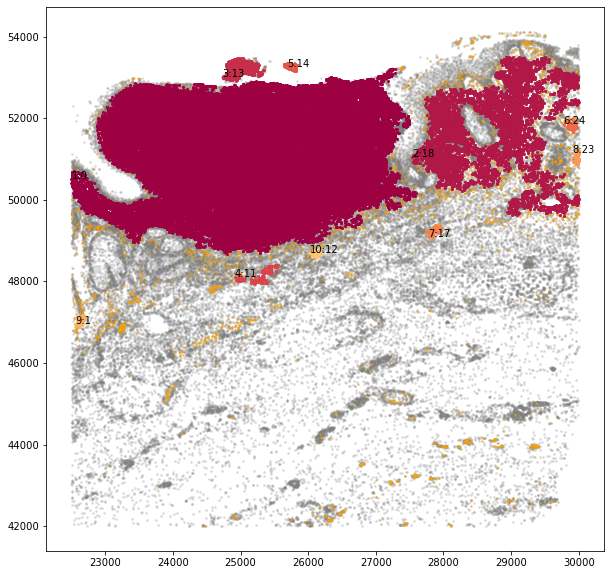

In [14]:
# input: output of getCommunities()
markersize = 2

labels_sorted = ret[0]
db = ret[1]
plot_first_n_clusters = 10

adata_tmp = adata[adata.obs[communitycolumn] > -2]
X = adata_tmp.obs[["X_centroid", "Y_centroid"]].to_numpy()
labels = db.labels_
unique_labels = set(labels)
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

fig, ax = plt.subplots(figsize=(10, 10))

## all points
ax.scatter(*zip(*adata.obs[["X_centroid", "Y_centroid"]].to_numpy()), 
           s=3, color="grey", alpha=0.2)

# Points of interest: outliers
ax.scatter(X[:,0], X[:,1], alpha=0.5, color="orange", s=markersize/2)

# clusters
idx = 0
for npoints, k in labels_sorted:
    if k == -1:
        continue
    if idx >= plot_first_n_clusters:
        break
        
    col = colors[idx] 
    class_member_mask = labels == k
    mask = class_member_mask & core_samples_mask
    xy = X[mask]
    plt.plot(xy[:, 0],xy[:, 1],
             "o",
             markerfacecolor=tuple(col),
             markeredgecolor=tuple(col),
             markersize=markersize,
            )
    # idx: the "idx" largest cluster
    # k: the cluster
    plt.annotate(str(idx+1)+":"+str(k), (xy[0, 0], xy[0, 1]))

    idx += 1

plt.show()
 

In [15]:
clusters_idx_sorted = [idx for npoints, idx in ret[0]]
print(clusters_idx_sorted[:plot_first_n_clusters])
print(ret[0][:plot_first_n_clusters])

[0, 18, 13, 11, 14, 24, 17, 23, 1, 12]
[(68743, 0), (8580, 18), (1222, 13), (217, 11), (161, 14), (97, 24), (75, 17), (67, 23), (62, 1), (59, 12)]


In [16]:
# Here we choose the three largest ones of interest
communityIndexList = [0, 18, 13]

# getBoundary    
# getExtendedBoundary

In [17]:
import importlib
import _utils
import _getBoundary
import _getExtendedBoundary
import _getshrunkenBoundary

In [18]:
importlib.reload(_utils)
from _utils import *

edges = np.array([[1,2], [1,3], [2,3], [3,4], [3,5], [4,5], [6,7], [6,8], [7,8]])

edges = np.array([[1,2], [1,3], [2,3], [3,4], [3,5], [4,5], 
                  [6,7], [6,8], [7,8], 
                  [8,9], [9,10], [8,10]
                 ])

edge_components = getOrderedEdgeComponents(edges)
print("number components:", len(edge_components))
for idx in range(len(edge_components)):
    print("Component", idx, ":")
    print(edge_components[idx])

number components: 3
Component 0 :
[[1 2]
 [2 3]
 [3 1]]
Component 1 :
[[3 4]
 [4 5]
 [5 3]]
Component 2 :
[[ 6  8]
 [ 8  9]
 [ 9 10]
 [10  8]
 [ 8  7]
 [ 7  6]]


In [19]:
importlib.reload(_utils)
from _utils import *

xy = adata.obs[adata.obs[communitycolumn].isin(communityIndexList)][
        ["X_centroid", "Y_centroid"]
    ].to_numpy()

edge_components = getAlphaShapes(xy, 100, debug=True)

edge_component_indices: 5
(352, 2)
(31, 2)
(197, 2)
(6, 2)
(12, 2)


In [20]:
importlib.reload(_utils)
importlib.reload(_getBoundary)
from _getBoundary import getBoundary
from _utils import *

boundaries = getBoundary(adata, 
                         communitycolumn, communityIndexList,
                         alpha=80, 
                         nedges_min = 20,
                         nedges_out_min = 20)


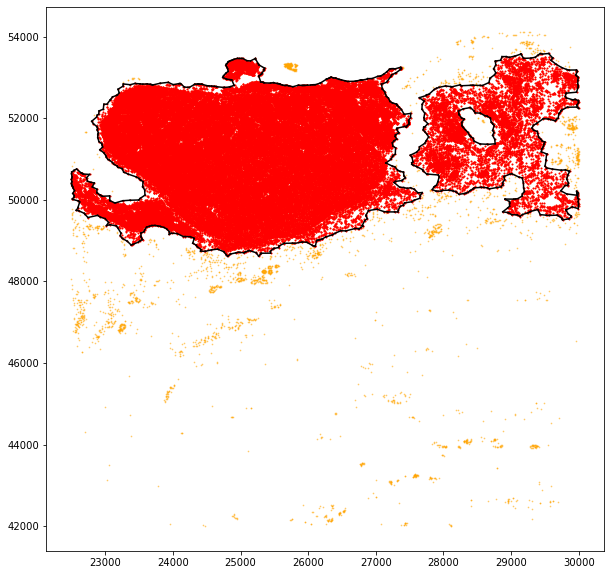

In [21]:
markersize = 1

fig, ax = plt.subplots(figsize=(10, 10))

## all points
ax.scatter(*zip(*adata.obs[["X_centroid", "Y_centroid"]].to_numpy()), 
           s=markersize//2, color="grey", alpha=0.2)

# Points of interest
ax.scatter(X[:,0], X[:,1], alpha=0.5, color="orange", s=markersize/2)

# Points in selected commnities
xy = adata.obs[adata.obs[communitycolumn].isin(communityIndexList)][
        ["X_centroid", "Y_centroid"]
    ].to_numpy()
ax.scatter(xy[:,0], xy[:,1], s=markersize, color="r")

# Bounds of points in selected commnities
for boundary_set in boundaries:
    for boundary in boundary_set:
        for edge in boundary:
            ax.plot(edge[:,0], edge[:,1], color="k")

plt.show()

In [48]:
importlib.reload(_utils)
from _utils import *
boundary_edges = getEdgesOnBoundary(boundaries)
print(boundary_edges.shape)
point = [23388.92105263, 48394.63157895]
if isInRegion(point, boundary_edges):
    print("In")

(694, 2, 2)


In [55]:
importlib.reload(_utils)
importlib.reload(_getExtendedBoundary)

from _utils import *
from _getExtendedBoundary import getExtendedBoundary

extended_boundaries, extended_pointsStretched = getExtendedBoundary(boundaries, 
                                                           offset=500, 
                                                           alpha=100)

get points on edges
get stretched points
get edge_components of stretched points
edge_components: 3 [540, 234, 8]


isIntersect: True


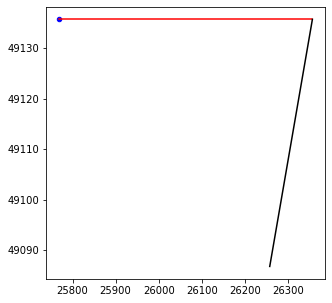

In [235]:
# Test isIntersect()

# point1 = [25767.923, 49135.692]
# point3 = [26356.804, 49138.608]
# point4 = [26257.756, 49086.756]
# point2 = [max(point3[0], point4[0]), 49135.692]

point1 = [25767.923, 49135.692]
point3 = [26356.804, 49135.692]
point4 = [26257.756, 49086.756]
point2 = [max(point3[0], point4[0]), 49135.692]

print("isIntersect:", isIntersect(point1, point2, point3, point4))

fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(point[0], point[1], s = 20, color="blue")
ax.plot([point1[0], point2[0]], [point1[1], point2[1]] , color="red")
ax.plot([point3[0], point4[0]], [point3[1], point4[1]] , color="black")

plt.show()

In [289]:
# Test isInRegion()

importlib.reload(_utils)
from _utils import *

boundary_edges = getEdgesOnBoundary(boundaries)

# point = [25767.923, 49135.692]
point = [27108.46153846,51730.25]
point = [23359.30237922,49988.64695972]

if isInRegion(point, boundary_edges, debug = True):
    print("in")
else:
    print("out")
    

isIntersect True [23365.86021505 49987.7311828 ] [23494.4375 49994.    ]
isIntersect True [27649.51724138 50035.10344828] [27568.32142857 49988.60714286]
isIntersect True [28909.26666667 50013.46666667] [28976.53571429 49956.17857143]
isIntersect True [29991.86792453 49953.05660377] [29998.20338983 50014.72881356]
count: 4 larger_y2_count 0 smaller_y2_count 0
out


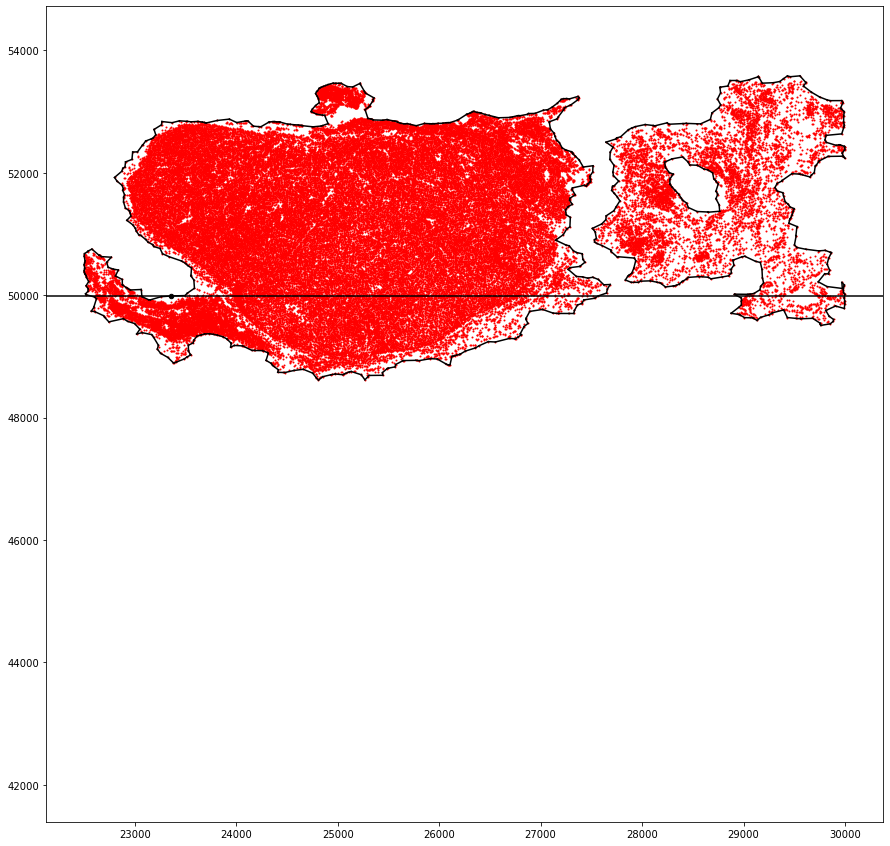

In [286]:
pointsize = 1
fig, ax = plt.subplots(figsize=(15, 15))

## all points
ax.scatter(*zip(*adata.obs[["X_centroid", "Y_centroid"]].to_numpy()), 
           s=markersize//2, color="grey", alpha=0.2)

# Points in selected commnities
xy = adata.obs[adata.obs[communitycolumn].isin(communityIndexList)][
        ["X_centroid", "Y_centroid"]
    ].to_numpy()
ax.scatter(xy[:,0], xy[:,1], s=markersize, color="r")

for boundary_set in boundaries:
    for boundary in boundary_set:
        for edges in boundary:
            ax.plot(edges[:,0], edges[:,1], color="k")

ax.scatter(point[0], point[1], s = 20, color="k")
plt.axhline(y = point[1], color = 'k', linestyle = '-')

# ax.plot([27313.26,27308.462], [51753.38,51729.25] , color="yellow")

plt.show()

In [323]:
importlib.reload(_utils)
importlib.reload(_getshrunkenBoundary)

from _utils import *
from _getshrunkenBoundary import getshrunkenBoundary


shrunken_boundaries = getshrunkenBoundary(boundaries, 
                                          offset=200, # bugs when offset is too small
                                          alpha=65) # bugs when offset is too small


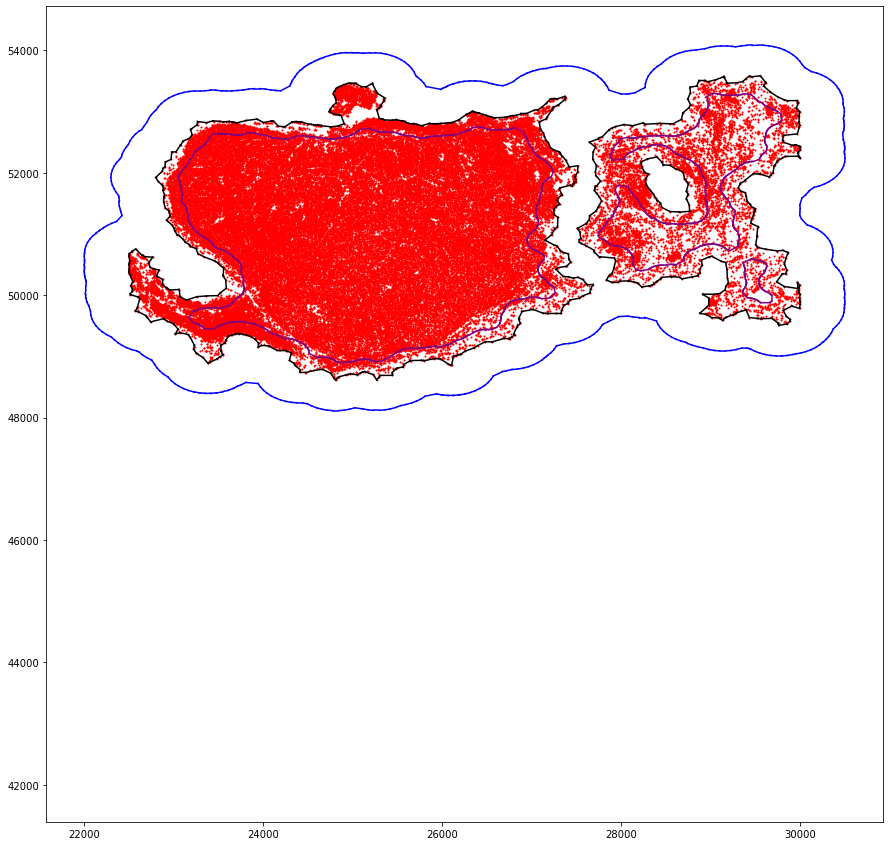

In [324]:
pointsize = 1
fig, ax = plt.subplots(figsize=(15, 15))

## all points
ax.scatter(*zip(*adata.obs[["X_centroid", "Y_centroid"]].to_numpy()), 
           s=markersize//2, color="grey", alpha=0.2)

# # Points of interest
# ax.scatter(X[:,0], X[:,1], alpha=0.5, color="orange", s=markersize/2)

# Points in selected commnities
xy = adata.obs[adata.obs[communitycolumn].isin(communityIndexList)][
        ["X_centroid", "Y_centroid"]
    ].to_numpy()
ax.scatter(xy[:,0], xy[:,1], s=markersize, color="r")

for boundary_set in boundaries:
    for boundary in boundary_set:
        for edges in boundary:
            ax.plot(edges[:,0], edges[:,1], color="k")

for ed in extended_boundaries:
    ax.plot(ed[:, 0], ed[:, 1], color="blue")

for ed in shrunken_boundaries:
    ax.plot(ed[:, 0], ed[:, 1], color="purple")

plt.show()

In [ ]:
# boundaries
# shrunken_boundaries
# extended_boundaries

In [325]:
regions = ["0In", "1Bi", "2Bo", "3Out"]
adata.obs["region"] = "3Out"
adata.obs["region"] = pd.Categorical(adata.obs["region"], categories=regions, ordered=True)

In [332]:
import _assignPointsToRegion

In [365]:
importlib.reload(_utils)
importlib.reload(_assignPointsToRegion)

from _utils import *
from _assignPointsToRegion import assignPointsToRegion

# 0In
target = "0In"
donelist = [target]
xv, yv, grid_label = assignPointsToRegion(adata, shrunken_boundaries, 
                     assigncolumn = "region",
                     target=target, donelist=donelist)


assigning a region for each cell... (8, 12) 23051 29791 48897 53300
assigning a region for each cell... (6, 6) 23051 23725 48897 49571
assigning a region for each cell... (6, 6) 23051 23219 49233 49401
assigning a region for each cell... (6, 6) 23219 23387 49233 49401
assigning a region for each cell... (6, 6) 23387 23555 49233 49401
assigning a region for each cell... (6, 6) 23051 23219 49401 49569
assigning a region for each cell... (6, 6) 23219 23387 49401 49569
assigning a region for each cell... (6, 6) 23387 23555 49401 49569
assigning a region for each cell... (6, 6) 23555 23723 49401 49569
assigning a region for each cell... (6, 6) 23725 24399 48897 49571
assigning a region for each cell... (6, 6) 24061 24229 49065 49233
assigning a region for each cell... (6, 6) 24229 24397 49065 49233
assigning a region for each cell... (6, 6) 23893 24061 49233 49401
assigning a region for each cell... (6, 6) 24061 24229 49233 49401
assigning a region for each cell... (6, 6) 23725 23893 49401 

assigning a region for each cell... (4, 6) 27769 28443 52941 53300
assigning a region for each cell... (4, 6) 28443 29117 52941 53300
assigning a region for each cell... (6, 6) 28779 28947 52941 53109
assigning a region for each cell... (4, 6) 29117 29791 52941 53300


In [371]:
# 1Bi
target = "1Bi"
donelist = ["0In", target]

boundary_edges = getEdgesOnBoundary(boundaries)
xv, yv, grid_label = assignPointsToRegion(adata, boundary_edges, 
                     assigncolumn = "region",
                     target=target, donelist=donelist)

assigning a region for each cell... (8, 12) 22499 30000 48611 53585
assigning a region for each cell... (6, 6) 22499 23249 48611 49361
assigning a region for each cell... (6, 6) 22873 23060 49172 49359
assigning a region for each cell... (6, 6) 23060 23247 49172 49359
assigning a region for each cell... (6, 6) 23249 23999 48611 49361
assigning a region for each cell... (6, 6) 23623 23810 48798 48985
assigning a region for each cell... (6, 6) 23249 23436 48985 49172
assigning a region for each cell... (6, 6) 23436 23623 48985 49172
assigning a region for each cell... (6, 6) 23249 23436 49172 49359
assigning a region for each cell... (6, 6) 23436 23623 49172 49359
assigning a region for each cell... (6, 6) 23810 23997 49172 49359
assigning a region for each cell... (6, 6) 23999 24749 48611 49361
assigning a region for each cell... (6, 6) 24186 24373 48611 48798
assigning a region for each cell... (6, 6) 24186 24373 48798 48985
assigning a region for each cell... (6, 6) 24373 24560 48798 

assigning a region for each cell... (6, 6) 28123 28310 52172 52359
assigning a region for each cell... (6, 6) 28310 28497 52172 52359
assigning a region for each cell... (6, 6) 28499 29249 51611 52361
assigning a region for each cell... (6, 6) 28686 28873 51611 51798
assigning a region for each cell... (6, 6) 28499 28686 51798 51985
assigning a region for each cell... (6, 6) 28686 28873 51798 51985
assigning a region for each cell... (6, 6) 28499 28686 51985 52172
assigning a region for each cell... (6, 6) 28686 28873 51985 52172
assigning a region for each cell... (6, 6) 29249 29999 51611 52361
assigning a region for each cell... (6, 6) 22499 23249 52361 53111
assigning a region for each cell... (6, 6) 23060 23247 52361 52548
assigning a region for each cell... (6, 6) 23249 23999 52361 53111
assigning a region for each cell... (6, 6) 23249 23436 52548 52735
assigning a region for each cell... (6, 6) 23436 23623 52548 52735
assigning a region for each cell... (6, 6) 23623 23810 52548 5

In [377]:
# 2Bo
target = "2Bo"
donelist = ["0In", "1Bi", target]

xv, yv, grid_label = assignPointsToRegion(adata, extended_boundaries, 
                     assigncolumn = "region",
                     target=target, donelist=donelist)

assigning a region for each cell... (9, 12) 21999 30500 48112 54084
assigning a region for each cell... (6, 6) 21999 22849 48112 48962
assigning a region for each cell... (6, 6) 22849 23699 48112 48962
assigning a region for each cell... (6, 6) 23699 24549 48112 48962
assigning a region for each cell... (6, 6) 24123 24335 48112 48324
assigning a region for each cell... (6, 6) 23911 24123 48324 48536
assigning a region for each cell... (6, 6) 23699 23911 48536 48748
assigning a region for each cell... (6, 6) 24549 25399 48112 48962
assigning a region for each cell... (6, 6) 24549 24761 48112 48324
assigning a region for each cell... (6, 6) 25399 26249 48112 48962
assigning a region for each cell... (6, 6) 25399 25611 48112 48324
assigning a region for each cell... (6, 6) 26249 27099 48112 48962
assigning a region for each cell... (6, 6) 27099 27949 48112 48962
assigning a region for each cell... (6, 6) 27949 28799 48112 48962
assigning a region for each cell... (6, 6) 28799 29649 48112 

In [378]:
adata.obs['region'].value_counts()

region
0In     66099
1Bi     29091
3Out    26666
2Bo     16059
Name: count, dtype: int64

In [379]:
adata.obs["region_numeric"] = 4
adata.obs.loc[adata.obs["region"] == "0In", "region_numeric"] = 0
adata.obs.loc[adata.obs["region"] == "1Bi", "region_numeric"] = 1
adata.obs.loc[adata.obs["region"] == "2Bo", "region_numeric"] = 2


In [380]:
print(grid_label)
# 1: in
# 0.5: has edge
# 0: out

[[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.  0.  0.  0.  0. ]
 [0.5 1.  1.  1.  1.  1.  0.5 0.5 0.5 0.5 0.  0. ]
 [0.5 1.  1.  1.  1.  1.  1.  1.  1.  0.5 0.  0. ]
 [0.5 1.  1.  1.  1.  1.  1.  1.  1.  0.5 0.  0. ]
 [0.5 1.  1.  1.  1.  1.  1.  1.  1.  0.5 0.  0. ]
 [0.5 0.5 1.  1.  1.  1.  1.  1.  1.  0.5 0.  0. ]
 [0.  0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.5 0.5 0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]]


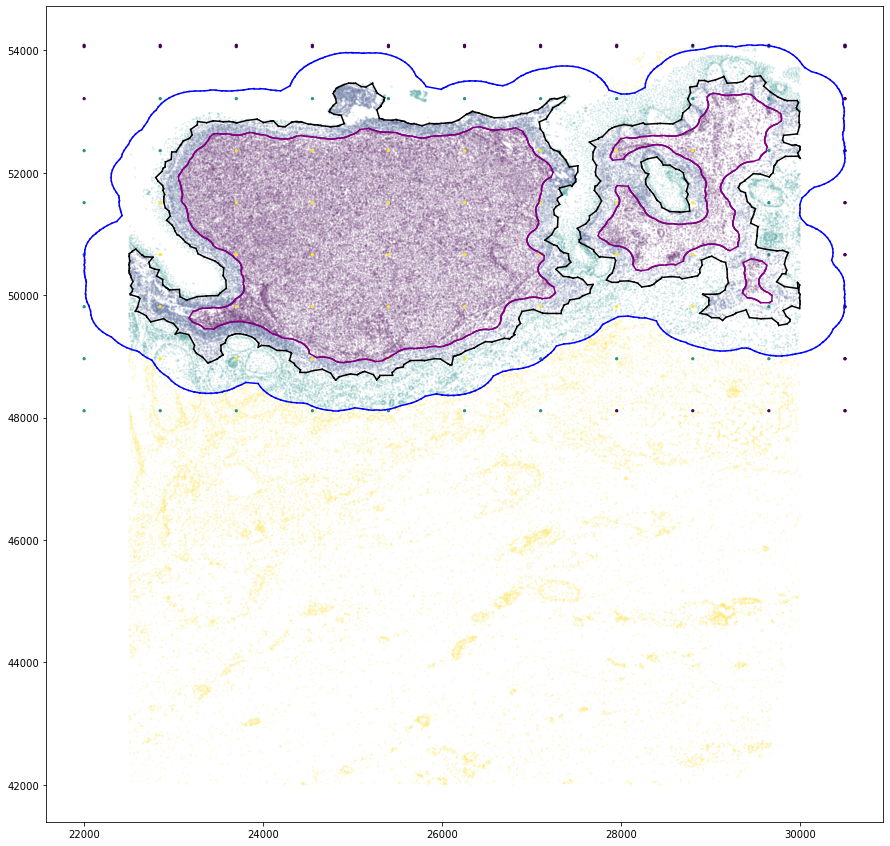

In [381]:

point_size = 1
fig, ax = plt.subplots(figsize=(15, 15))

ax.scatter(*zip(*adata.obs[["X_centroid", "Y_centroid"]].to_numpy()), 
           s=point_size, c=list(adata.obs.region_numeric), alpha=0.1)

for boundary_set in boundaries:
    for boundary in boundary_set:
        for edges in boundary:
            ax.plot(edges[:,0], edges[:,1], color="k")

for ed in shrunken_boundaries:
    ax.plot(ed[:, 0], ed[:, 1], color="purple")

for ed in extended_boundaries:
    ax.plot(ed[:, 0], ed[:, 1], color="blue")


plt.show()